[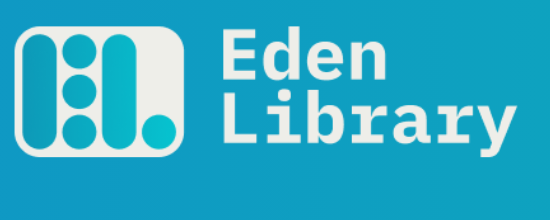](http://edenlibrary.ai/)
# Plant Segmentation-Background Removal-2

## Instructions
1. Clone the repository.
2. Download the necessary datasets from Eden Repository:
   1. Broccoli-080919-Healthy-zz-V1-20210223132111
3. Unzip dataset files and remove the zip files.
4. Create a folder called 'eden_data'.
5. Move the unzipped datasets into this folder.
6. The resulting directory structure should be:
    * working_directory/image_preprocessing/
       * Background removal-Manual Method.ipynb
       * eden_data/
           * Broccoli-080919-Healthy-zz-V1-XXX...
7. Install notebook dependencies by running:
    <pre><code>conda create -n name_of_environment --file eden-package-list.txt</code></pre>
8. Open the notebook: jupyter notebook
9. Run the code

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will reply you as soon as possible.

## Background (Go to [Biobliography](#references) for more details)

In order to improve the performance of a deep-learning-based system, many times a pre-processing step known as background removal is applied. This technique is supposed to remove as much noise/background from the image, making the object of study appearing as the main part of the picture. 

In **agriculture**, several works have made use of background removal techniques for achieving a better performance (Mohanty et al., 2016; McCool et al., 2017; Milioto et al., 2017). In this notebook, we are gonna use a specific technique, where the HSV color-space representation (see Figure) will provide us with a better model for separating by thresholding the background and foreground parts of the image.

[<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/HSV_color_solid_cylinder_saturation_gray.png/800px-HSV_color_solid_cylinder_saturation_gray.png" style="width:20%;">](https://en.wikipedia.org/wiki/HSL_and_HSV)

Specifically, the algorithm can summarised like this:
1. Use gaussian blur for remove noise
2. Convert color to HSV 
3. Create mask
4. Create boolean mask
5. Apply boolean mask and getting image whithout background

In [1]:
import numpy as np
import cv2
from tqdm import tqdm
from glob import glob

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def read_data(path, im_size=(128,128)):
    X = []
    for im_file in tqdm(glob(path)):
        if im_file.lower().endswith("jpg"):
            try:
                label = im_file.split("/")[1]
                im = cv2.imread(im_file)
                im = cv2.resize(im, im_size)
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                X.append(im)
            except Exception as e:
                print(e)
    
    X = np.array(X, np.uint8)
    return X

In [3]:
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [4]:
X = read_data('eden_data/*/*')

100%|██████████| 94/94 [00:08<00:00, 17.21it/s]


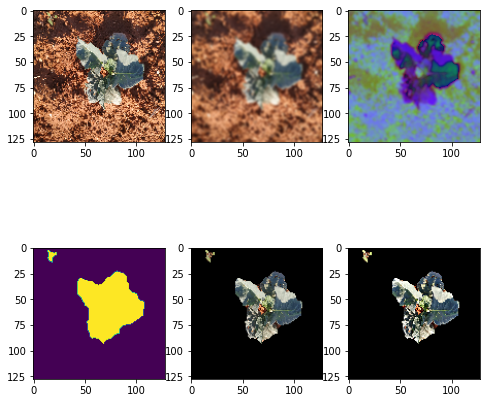

In [5]:
MIN_HUE = 0; MAX_HUE = 100
MIN_SAT = 0; MAX_SAT = 220
MIN_VAL = 0; MAX_VAL = 220

LOWER_GREEN = (MIN_HUE, MIN_SAT, MIN_VAL)
UPPER_GREEN = (MAX_HUE, MAX_SAT, MAX_VAL)
HOMOGENEOUS_SHAPE = (11, 11)
BLUR_LEVEL = (5, 5)

img = X[0]

# Use gaussian blur
blur_img = cv2.GaussianBlur(img, BLUR_LEVEL, 0)

# Convert to HSV image
hsv_img = cv2.cvtColor(blur_img, cv2.COLOR_BGR2HSV)  

# Create mask (parameters - green color range)
mask = cv2.inRange(hsv_img, LOWER_GREEN, UPPER_GREEN)  
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, HOMOGENEOUS_SHAPE)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Create boolean mask
b_mask = mask > 0  

# Apply the mask
clear = np.zeros_like(img, np.uint8)  # Create empty image
clear[b_mask] = img[b_mask]  # Apply boolean mask to the origin image

# Show examples
plt.figure(figsize=(8, 8))
plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
plt.subplot(2, 3, 2); plt.imshow(blur_img)  # Blur image
plt.subplot(2, 3, 3); plt.imshow(hsv_img)  # HSV image
plt.subplot(2, 3, 4); plt.imshow(b_mask)  # Boolean mask
plt.subplot(2, 3, 5); plt.imshow(clear)  # Image with removed background
plt.subplot(2, 3, 6); plt.imshow(sharpen_image(clear)) # Sharpened version of the image

### Biobliography
<a id='references'></a>
McCool, C., Perez, T., Upcroft, B., 2017. Mixtures of lightweight deep convolutional neural networks: applied to agricultural robotics. IEEE Rob. Autom. Lett. 2 (3), 1344–1351.

Milioto, A., Lottes, P., Stachniss, C., 2017. Real-time blob-wise sugar beets vs weeds classification for monitoring fields using convolutional neural networks. Proceedings of the International Conference on Unmanned Aerial Vehicles in Geomatics. Bonn, Germany.

Mohanty, S.P., Hughes, D.P., Salathé, M., 2016. Using deep learning for image-based plant disease detection. Front. Plant. Sci. 7.

https://www.cs.auckland.ac.nz/courses/compsci773s1c/lectures/ImageProcessing-html/topic4.htm

### Acknowledgements
This notebook was highly inspired by the work of **Gábor Vecsei** (https://www.kaggle.com/gaborvecsei/plant-seedlings-fun-with-computer-vision)